# Gan

This notebook covers the process of building a Generative Adversarial Network (GAN) and it's application to the `MNIST` dataset.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision.transforms as T
import torchvision.utils as vutils
from torchvision.datasets import MNIST
from torch.nn.functional import binary_cross_entropy

from pathlib import Path
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")
print("using device", DEVICE)

using device cpu


As example `MNIST` dataset will be used.

In [2]:
TRAIN_DATASET = MNIST(
    Path("mnist_files"),
    download=True,
    train=True,
    transform=T.ToTensor()
)
DATA_LOADER = DataLoader(TRAIN_DATASET, batch_size=64)

In [3]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Basics

At the begining consider network that just tries imitate digits that are in the mnist dataset. 

### Generator

Following cell implements `Generator` class.

In [4]:
class Generator(nn.Module):
    '''
    A class that generates a picture from a set of random noise.

    Parameters
    ----------
    feature_map_size: int
        Feature map's size of the generator.
    number_channels: int
        Number of input channels.
    noize_size: int
        Size of the vector that is expected to be transformed to the picture by 
        the model.
    '''
    def __init__(
        self, 
        feature_map_size: int, 
        number_channels: int, 
        noize_size: int
    ) -> None:
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # (nz) x 1 x 1
            nn.ConvTranspose2d(
                in_channels=noize_size, 
                out_channels=feature_map_size * 2, 
                kernel_size=7,
                stride=1, 
                padding=0, 
                bias=False
            ),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.ReLU(True),

            # (feature_map_size*2) x 7 x 7
            nn.ConvTranspose2d(
                in_channels=feature_map_size * 2, 
                out_channels=feature_map_size, 
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False
            ),
            nn.BatchNorm2d(feature_map_size),
            nn.ReLU(True),

            # (feature_map_size) x 14 x 14
            nn.ConvTranspose2d(
                in_channels=feature_map_size, 
                out_channels=number_channels, 
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False
            ),
            nn.Tanh(),
            # (nc) x 28 x 28
        )

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        '''
        Apply model to given data.

        Paramaters
        ----------
        input: torch.Tensor
            Tensor with size (n_samples, self.nz)

        Returns
        -------
        out: torch.Tensor
            Tensor that represents set of generated pictures.
        '''
        return self.main(input[:, :, None, None])

Now let's check what options there are to use it: to generator you have to pass vectors with random values. For each random vertor it will return picture.

In [5]:
generator = Generator(
    feature_map_size=64, 
    number_channels=1, 
    noize_size=100
)
generator(torch.randn(20, 100)).shape

torch.Size([20, 1, 28, 28])

### Discriminator

The discriminator is a model that tries to determine if a picture was created by the generator or not. The following cell defines the generator that we will use for this example.

In [6]:
class Discriminator(nn.Module):
    '''
    Realisation of the discriminator. Class that takes picture and generate scor
    which expresses how much the model thinks the picture is generated.

    Parameters
    ----------
    number_channels: int
        Number of channels in input.
    feature_map_size: int
        Feature map's size.
    '''

    def __init__(self, number_channels: int, feature_map_size: int):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # (number_channels) x 28 x 28
            nn.Conv2d(
                in_channels=number_channels, 
                out_channels=feature_map_size, 
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True),


            # (feature_map_size) x 14 x 14
            nn.Conv2d(
                in_channels=feature_map_size, 
                out_channels=feature_map_size * 2, 
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False
            ),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.LeakyReLU(0.2, inplace=True),


            # (feature_map_size*2) x 7 x 7
            nn.Conv2d(
                in_channels=feature_map_size * 2, 
                out_channels=1, 
                kernel_size=7, 
                stride=1, 
                padding=0, 
                bias=False
            ),
            
            nn.Sigmoid(),
            nn.Flatten(start_dim=0, end_dim=-1)
        )

    def forward(self, input):
        return self.main(input)

Consider how the discriminator works by passing a sample picture from the training data to it:

In [7]:
discriminator = Discriminator(
    number_channels=1, 
    feature_map_size=64
)
discriminator(TRAIN_DATASET[0][0][None, :, :, :])

tensor([0.4926], grad_fn=<ViewBackward0>)

We got a score that represents the model's prediction of whether the picture we passed was generated.

## Model fitting

In [8]:
feature_map_size = 64
noise_size = 100

netG = Generator(
    feature_map_size=feature_map_size, 
    number_channels=1, 
    noize_size=noise_size
).to(DEVICE)
netG = netG.apply(weights_init)

netD = Discriminator(
    feature_map_size=feature_map_size, 
    number_channels=1
).to(DEVICE)
netD = netD.apply(weights_init)

lr = 0.001
beta1 = 0.5

# We'll draw images from the same input to compare results.
fixed_noise = torch.randn(64, noise_size, device=DEVICE)

# Labels for real and fake images
real_label, fake_label = 1., 0.

optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [9]:
def discriminator_step(
    pictures: torch.Tensor,
    generation: torch.Tensor,
    discriminator: torch.nn.Module,
    optimizer: torch.optim.Optimizer
):
    '''
    Step of the discriminator. Maximize log(D(x)) + log(1 - D(G(z))) - tries to 
    to improve the prediction that the real images have 1. scores and the 
    generated images have have 0. scores.
    '''

    batch_size = pictures.shape[0]

    # Gradient accumulation on real images
    discriminator.zero_grad()
    label = torch.full((batch_size,), 1., dtype=torch.float, device=DEVICE)
    output = discriminator(pictures)
    errD_real = binary_cross_entropy(output, label)
    errD_real.backward()
    D_x = output.mean().item()

    # Gradient accumulation on fake images
    label.fill_(fake_label)
    output = discriminator(generation.detach())
    errD_fake = binary_cross_entropy(output, label)
    errD_fake.backward()
    D_G_z1 = output.mean().item()
    errD = errD_real + errD_fake

    # Step based on accumulated gradients
    optimizer.step()

    return D_x, D_G_z1, errD

In [10]:
img_list = []
G_losses = []
D_losses = []
iters = 0

num_epochs = 1

for epoch in range(num_epochs):
    for i, (pictures, _) in enumerate(DATA_LOADER, 0):
        pictures = pictures.to(DEVICE)
        batch_size = pictures.size(0)
        
        # Getting generated ("fake") picture that tries to trick discriminator
        noise = torch.randn(batch_size, noise_size, device=DEVICE)
        fake = netG(noise)

        D_x, D_G_z1, errD = discriminator_step(
            pictures=pictures,
            generation=fake,
            discriminator=netD,
            optimizer=optimizerD
        )

        # Maximizing for generator log(D(G(z)))
        netG.zero_grad()
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=DEVICE)
        output = netD(fake)
        errG = binary_cross_entropy(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 50 == 0:
            print(
                "[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(DATA_LOADER),
                    errD.item(),
                    errG.item(),
                    D_x,
                    D_G_z1,
                    D_G_z2,
                )
            )
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        if (iters % 500 == 0) or (
            (epoch == num_epochs - 1) and (i == len(DATA_LOADER) - 1)
        ):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        iters += 1

[0/1][0/938]	Loss_D: 2.8116	Loss_G: 2.6194	D(x): 0.1223	D(G(z)): 0.2820 / 0.0932
[0/1][50/938]	Loss_D: 1.2805	Loss_G: 10.2501	D(x): 0.9953	D(G(z)): 0.6238 / 0.0001
[0/1][100/938]	Loss_D: 0.8899	Loss_G: 2.3883	D(x): 0.4925	D(G(z)): 0.0013 / 0.1565
[0/1][150/938]	Loss_D: 0.1096	Loss_G: 4.6373	D(x): 0.9740	D(G(z)): 0.0739 / 0.0140
[0/1][200/938]	Loss_D: 0.0962	Loss_G: 4.5319	D(x): 0.9323	D(G(z)): 0.0237 / 0.0171
[0/1][250/938]	Loss_D: 0.2454	Loss_G: 4.7991	D(x): 0.9871	D(G(z)): 0.1906 / 0.0165
[0/1][300/938]	Loss_D: 1.2189	Loss_G: 2.4034	D(x): 0.3960	D(G(z)): 0.0036 / 0.1661
[0/1][350/938]	Loss_D: 0.3990	Loss_G: 2.2109	D(x): 0.8651	D(G(z)): 0.2049 / 0.1399
[0/1][400/938]	Loss_D: 0.1726	Loss_G: 5.5196	D(x): 0.8615	D(G(z)): 0.0110 / 0.0110
[0/1][450/938]	Loss_D: 0.2412	Loss_G: 7.0861	D(x): 0.8026	D(G(z)): 0.0012 / 0.0034
[0/1][500/938]	Loss_D: 0.5960	Loss_G: 4.7837	D(x): 0.9621	D(G(z)): 0.3752 / 0.0128
[0/1][550/938]	Loss_D: 0.0552	Loss_G: 4.2920	D(x): 0.9689	D(G(z)): 0.0222 / 0.0186
[0/1][

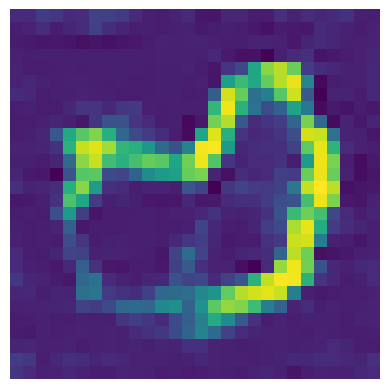

In [13]:
noize = torch.randn(1, noise_size, device=DEVICE)
plt.imshow(netG(noize).squeeze().detach().numpy())
plt.axis(False)
plt.show()

## Conditional

Here, we consider a modification of the previous model. The model shown in this section will draw a picture of the given class.

In [4]:
# Generator's feature map
ngf = 64
# Input channels
nc = 1
# Size of the vector from which generator will create a picture
nz = 100

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.embedding = nn.Embedding(
            num_embeddings=10,
            embedding_dim=10
        )

        self.main = nn.Sequential(
            # (nz) x 1 x 1
            nn.ConvTranspose2d(
                in_channels=nz+10,
                out_channels=ngf * 2, 
                kernel_size=7,
                stride=1, 
                padding=0, 
                bias=False
            ),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # (ngf*2) x 7 x 7
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # (ngf) x 14 x 14
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh(),
            # (nc) x 28 x 28
        )

    def forward(self, input, labels):
        ohe_labels = self.embedding(labels)[:, :, None, None]
        input = torch.cat([input, ohe_labels], dim=1)
        return self.main(input)

# Discriminator's feature map
ndf = 64

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.embedding = torch.nn.Embedding(
            num_embeddings=10, 
            embedding_dim=28 * 28
        )
        self.main = nn.Sequential(
            # (nc) x 28 x 28
            nn.Conv2d(
                in_channels=nc+1, 
                out_channels=ndf, 
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True),


            # (ndf) x 14 x 14
            nn.Conv2d(
                in_channels=ndf, 
                out_channels=ndf * 2, 
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False
            ),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),


            # (ndf*2) x 7 x 7
            nn.Conv2d(
                in_channels=ndf * 2, 
                out_channels=1,
                kernel_size=7, 
                stride=1, 
                padding=0, 
                bias=False
            ),
            nn.Sigmoid()
        )

    def forward(self, input, labels):
        labels = self.embedding(labels).reshape_as(input)
        input = torch.cat([input, labels], dim=1)
        return self.main(input)

In [5]:
netG = Generator().to(DEVICE)
netG = netG.apply(weights_init)

netD = Discriminator().to(DEVICE)
netD = netD.apply(weights_init)

criterion = nn.BCELoss()

lr = 0.001
beta1 = 0.5

# We'll draw images from the same input to compare results.
fixed_noise = torch.randn(64, nz, 1, 1, device=DEVICE)

# Labels for real and fake images
real_label, fake_label = 1., 0.

optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
img_list = []
G_losses = []
D_losses = []
iters = 0

num_epochs = 10

for epoch in range(num_epochs):
    for i, (X, y) in enumerate(DATA_LOADER, 0):
        real_batch = X.to(DEVICE)
        batch_size = real_batch.size(0)
        

        # Maximazing over discriminator log(D(x)) + log(1 - D(G(z)))
        # Step on the real image
        netD.zero_grad()
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=DEVICE)
        output = netD(real_batch, y).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Step on the fake image
        noise = torch.randn(batch_size, nz, 1, 1, device=DEVICE)
        fake = netG(noise, y)
        label.fill_(fake_label)
        output = netD(fake.detach(), y).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Maximizing for generator log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake, y).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 50 == 0:
            print(
                "[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(DATA_LOADER),
                    errD.item(),
                    errG.item(),
                    D_x,
                    D_G_z1,
                    D_G_z2,
                )
            )
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        if (iters % 500 == 0) or (
            (epoch == num_epochs - 1) and (i == len(DATA_LOADER) - 1)
        ):
            with torch.no_grad():
                fake = netG(fixed_noise, y).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        iters += 1

The following cell shows the result of the obtained network. In the `number` variable, you can specify the number to draw, and the result from the model will be displayed.

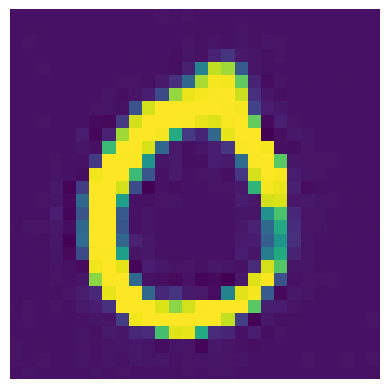

In [116]:
noise = torch.randn(1, nz, 1, 1, device=DEVICE)
number = 0

res = netG(
    noise, 
    torch.tensor([number])
)
plt.imshow(res.squeeze().detach().numpy())
plt.axis(False)
plt.show()